<a href="https://colab.research.google.com/github/victorncg/financas_quantitativas/blob/main/C%C3%B3digo_Google_Trends_vers%C3%A3o_jun_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://tradingcomdados.com/images/logotipo/logotipo-trading-com-dados.svg" width="300" align="left"/>

---
# **Dados alternativos podem gerar algum alpha?**


## *Um pequeno estudo usando a biblioteca pytrends*

<img src="https://googlemanager.be/wp-content/uploads/2020/03/trends.png" width="100" align="left"/>

Os nossos objetivos nesta aula serão os seguintes:

1. Conhecer a lib PyTrends, entender como funciona e como captura os dados do Google Trends
2. Entender as principais funções e métodos da biblioteca e entender sua sintaxe
3. Desenvolver formas de como utilizar essas informações no mercado financeiro

# **O que é o Google Trends**

<img src="https://github.com/victorncg/financas_quantitativas/blob/main/GOOGLE%20TRENDS.png?raw=true" width="1000" align="left"/>

Link: https://trends.google.com/trends

# **Pytrends**

E a PyTrends, como entra nessa história?

Perceba que o Google Trends NÃO possui uma API de fato.

O que a Pytrends faz é acessar a página do Google Trends por trás como se fosse uma API, fazendo os requests de acordo com os pedidos do usuário

Isso fica ainda mais claro quando você verifica a documentação.

Para você usar como referência:

Documentação no PyPi: https://pypi.org/project/pytrends/

Código-fonte no Github: https://github.com/GeneralMills/pytrends

Como a lib faz os requests: https://github.com/GeneralMills/pytrends/blob/master/pytrends/request.py

FAQ e maior detalhamento dos métodos

https://lazarinastoy.com/the-ultimate-guide-to-pytrends-google-trends-api-with-python/

# **0. Instalando as bibliotecas**

In [ ]:
!pip install pytrends
!pip install vectorbt

In [ ]:
from pytrends.request import TrendReq
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import datetime

# **1. Entendendo a biblioteca Pytrends**

## 1.1. Exploração inicial

Na primeira seção da nossa aula, vamos fazer uma obtenção básica de dados do Google Trends e tentar tirar algumas conclusões.

A nossa primeira tarefa é setar os parâmetros básicos da nossa requisição.

Faremos isso com a função "TrendReq"

In [103]:
pytrends = TrendReq(hl = 'pt-BR', tz = 360)

Aparentemente podemos fazer as requisições tanto em inglês quanto português.

In [104]:
termos = ['petrobras', 'dólar']

In [105]:
pytrends.build_payload(termos, cat = 0, timeframe = 'all', geo = 'BR', gprop = '')
busca = pytrends.interest_over_time()

Valores possívels para o argumento 'timeframe':

* Defaults to last 5yrs, 'today 5-y'.

* Everything 'all'

* Specific dates, 'YYYY-MM-DD YYYY-MM-DD' example '2016-12-14 2017-01-25'

* Specific datetimes, 'YYYY-MM-DDTHH YYYY-MM-DDTHH' example '2017-02-06T10 2017-02-12T07'
Note Time component is based off UTC

* Current Time Minus Time Pattern:

* By Month: 'today #-m' where # is the number of months from that date to pull data for

For example: 'today 3-m' would get data from today to 3months ago
NOTE Google uses UTC date as 'today'
Works for 1, 3, 12 months only!
Daily: 'now #-d' where # is the number of days from that date to pull data for

For example: 'now 7-d' would get data from the last week
Works for 1, 7 days only!
Hourly: 'now #-H' where # is the number of hours from that date to pull data for

For example: 'now 1-H' would get data from the last hour
Works for 1, 4 hours only!

Vamos verificar a periodicidade do dado

In [106]:
busca.head()

,petrobras,dólar,isPartial
date,,,
2004-01-01,64,5,False
2004-02-01,77,8,False
2004-03-01,32,5,False
2004-04-01,27,5,False
2004-05-01,35,6,False


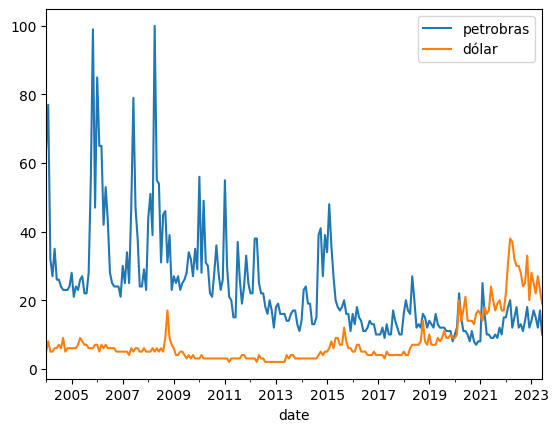

In [108]:
busca[['petrobras', 'dólar']].plot();

Vamos desenvolver uma rotina que faz tudo isso de uma só vez, e tem como output o gráfico que mostramos acima.

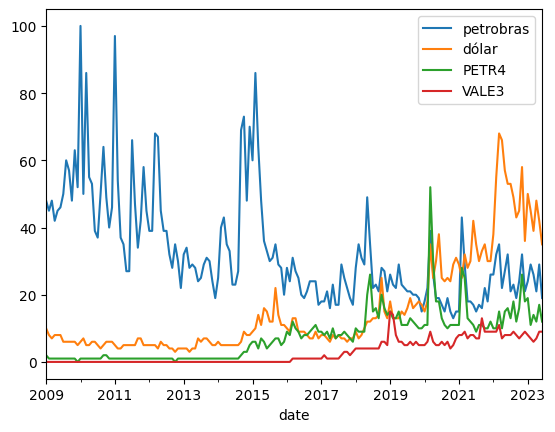

In [138]:
pytrends = TrendReq(hl = 'pt-BR', tz = 360)
lista_termos = ['petrobras', 'dólar', 'PETR4', 'VALE3']
pytrends.build_payload(lista_termos, cat = 0, timeframe = '2008-12-14 2023-06-14', geo = 'BR', gprop = '')
busca = pytrends.interest_over_time()
busca[['petrobras', 'dólar', 'PETR4','VALE3']].plot();

## 1.2. Cruzamento das informações do Google Trends com Mercado Financeiro

### 1.2.1. Pré-processamento do dado

In [139]:
busca['Date'] = busca.index

In [140]:
busca.shape

(174, 6)

In [141]:
busca.index = busca['Date']

In [142]:
busca.index = pd.to_datetime(busca.index)

In [143]:
busca.drop(['Date'], axis = 1, inplace = True)

In [144]:
busca.head()

,petrobras,dólar,PETR4,VALE3,isPartial
Date,,,,,
2009-01-01,48,10,2,0,False
2009-02-01,45,8,1,0,False
2009-03-01,48,7,1,0,False
2009-04-01,42,8,1,0,False
2009-05-01,45,8,1,0,False


In [145]:
busca.index[0].strftime("%Y-%m-%d")

'2009-01-01'

In [146]:
import yfinance as yf
import pandas as pd
dolar = pd.DataFrame(yf.download('USDBRL=X', start = busca.index[0].strftime("%Y-%m-%d"))['Adj Close'])

[*********************100%***********************]  1 of 1 completed


In [147]:
dolar.index = pd.to_datetime(dolar.index)

In [148]:
dolar.head()

,Adj Close
Date,
2009-01-01,2.3240
2009-01-02,2.3130
2009-01-05,2.2165
2009-01-06,2.1390
2009-01-07,2.1725


In [149]:
total = pd.merge(busca, dolar, how = 'inner', on = 'Date')[['dólar', 'Adj Close']]

In [150]:
total.sort_values(by='Date', inplace = True)

In [151]:
total.head()

,dólar,Adj Close
Date,,
2009-01-01,10,2.3240
2009-04-01,8,2.2785
2009-05-01,8,2.1800
2009-07-01,6,1.9280
2009-09-01,6,1.9130


In [152]:
dolar.dtypes

Adj Close    float64
dtype: object

In [153]:
busca.dtypes

petrobras    int64
dólar        int64
PETR4        int64
VALE3        int64
isPartial     bool
dtype: object

### 1.2.2. Plotagem da informação

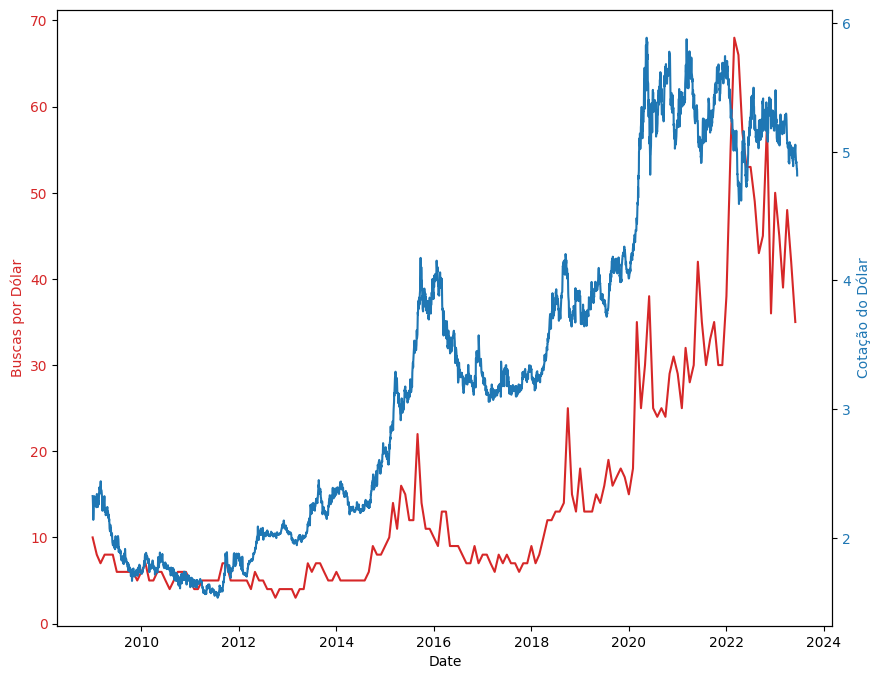

In [154]:
fig, ax1 = plt.subplots(figsize = (10,8))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Buscas por Dólar', color=color)
ax1.plot(busca.index,busca['dólar'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() # Configurar um outro eixo vertical que compartilha o mesmo eixo X

color = 'tab:blue'
ax2.set_ylabel('Cotação do Dólar', color=color)
ax2.plot(dolar.index,dolar, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

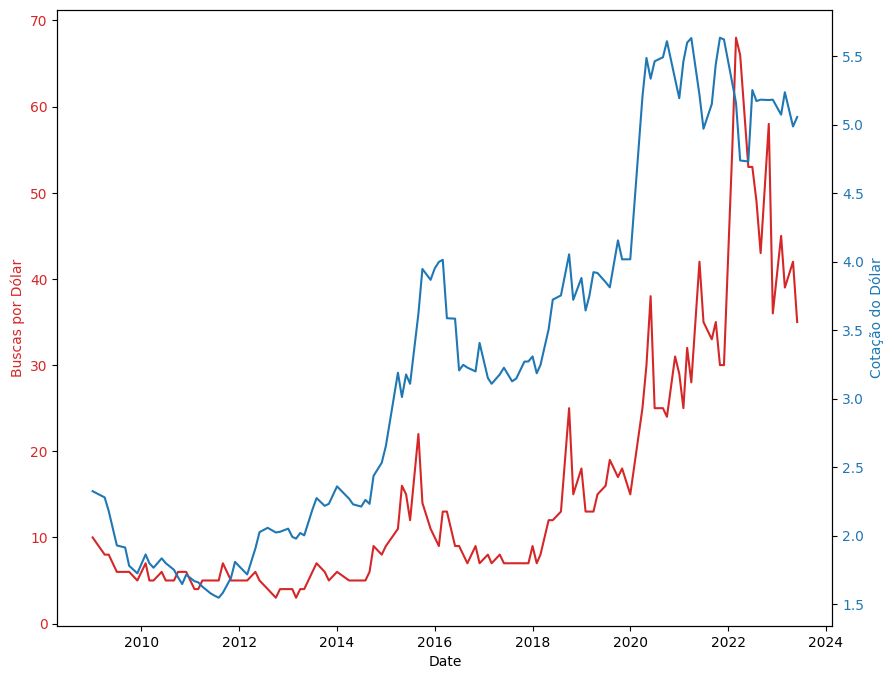

In [155]:
fig, ax1 = plt.subplots(figsize = (10,8))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Buscas por Dólar', color=color)
ax1.plot(total['dólar'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() # Configurar um outro eixo vertical que compartilha o mesmo eixo X

color = 'tab:blue'
ax2.set_ylabel('Cotação do Dólar', color=color)
ax2.plot(total['Adj Close'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

**Obs**: Modifique o período de busca e verifique como os gráficos mudam

In [156]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x = busca.index, y = busca['dólar'], name="yaxis data"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter(x = dolar.index, y = dolar['Adj Close'], name="yaxis2 data"),
    secondary_y=False,
)

# Add figure title
fig.update_layout(
    title_text="Double Y Axis Example"
)

# Set x-axis title
fig.update_xaxes(title_text="xaxis title")

# Set y-axes titles
fig.update_yaxes(title_text="<b>primary</b> yaxis title", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> yaxis title", secondary_y=True)

fig.show()

### 1.2.3. Comparativo de ações

E como ficam as buscas por temáticas do mercado financeiro? Qual papel é pesquisado mais? Vamos fazer uma exploração.

In [157]:
pytrends = TrendReq(hl = 'en-US', tz = 360)

In [160]:
kw_list = ['PETR4', 'ABEV3','ITUB4','WEGE3', 'VALE3']

In [166]:
pytrends.build_payload(kw_list, cat = 0, timeframe = '2015-01-01 2023-06-14', geo = 'BR', gprop = '')
teste = pytrends.interest_over_time()

In [167]:
teste.columns

Index(['PETR4', 'ABEV3', 'ITUB4', 'WEGE3', 'VALE3', 'isPartial'], dtype='object')

Vamos verificar a periodicidade do dado

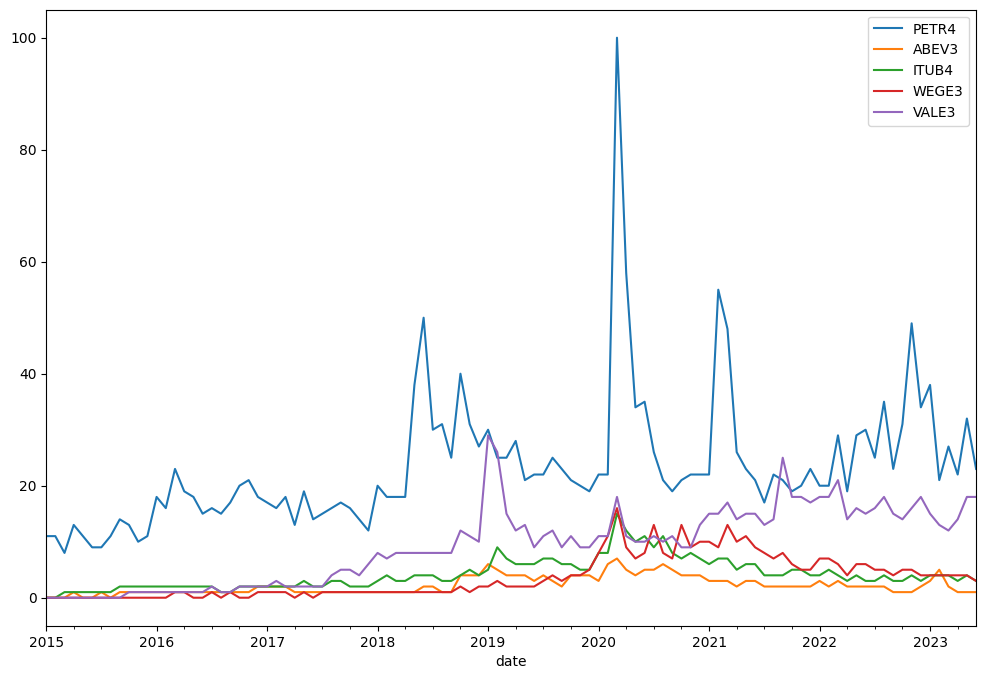

In [168]:
teste[['PETR4', 'ABEV3', 'ITUB4', 'WEGE3', 'VALE3']].plot(figsize = (12,8));

Utilizando o que aprendemos até aqui, vamos ver o movimento das buscas por petrobrás com o preço da ação

### 1.2.4. Petrobras vs. PETR4

In [172]:
pytrends = TrendReq(hl = 'pt-BR', tz = 360)
lista_termos = ['petrobras', 'PETR4']
pytrends.build_payload(lista_termos, cat = 0, timeframe = 'today 5-y', geo = 'BR', gprop = '')
busca_petro = pytrends.interest_over_time()

In [173]:
busca_petro['Date'] = busca_petro.index

In [174]:
busca_petro.shape

(261, 4)

In [ ]:
busca_petro.index = busca_petro['Date']

In [175]:
busca_petro.index = pd.to_datetime(busca_petro.index)

In [176]:
busca_petro.drop(['Date'], axis = 1, inplace = True)

In [186]:
busca_petro['Total'] = busca_petro['petrobras'] + busca_petro['PETR4']

In [177]:
busca_petro.head()

,petrobras,PETR4,isPartial
date,,,
2018-06-17,25,20,False
2018-06-24,22,17,False
2018-07-01,22,18,False
2018-07-08,20,15,False
2018-07-15,21,15,False


In [178]:
busca_petro.index[0].strftime("%Y-%m-%d")

'2018-06-17'

In [191]:
import yfinance as yf
import pandas as pd
petro = pd.DataFrame(yf.download('PETR4.SA', start = busca_petro.index[0].strftime("%Y-%m-%d")))

[*********************100%***********************]  1 of 1 completed


In [192]:
petro.index = pd.to_datetime(petro.index)

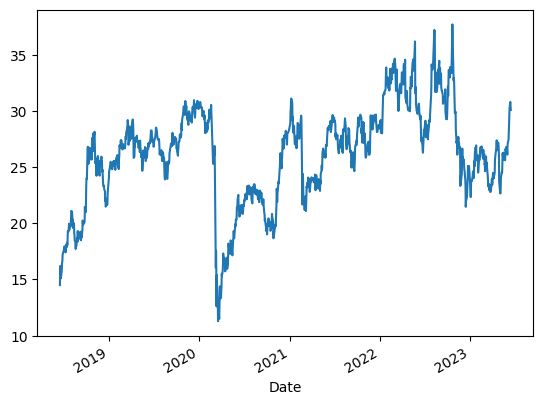

In [193]:
petro['Close'].plot();

In [185]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x = busca_petro.index, y = busca_petro['petrobras'], name="Buscas por Petrobras"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x = busca_petro.index, y = busca_petro['PETR4'], name="Buscas por PETR4"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x = petro.index, y = petro['Adj Close'], name="Cotação de PETR4"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Cotação de PETR4 vs. buscas no Google"
)

# Set x-axis title
fig.update_xaxes(title_text="Data")

# Set y-axes titles
fig.update_yaxes(title_text="<b>primary</b> Intensidade das buscas", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> Preço de PETR4", secondary_y=True)

fig.show()

In [188]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x = busca_petro.index, y = busca_petro['Total'], name="Buscas por Petrobras"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x = petro.index, y = petro['Adj Close'], name="Cotação de PETR4"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Cotação de PETR4 vs. buscas no Google"
)

# Set x-axis title
fig.update_xaxes(title_text="Data")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Eixo 01</b> Intensidade das buscas", secondary_y=False)
fig.update_yaxes(title_text="<b>Eixo 02</b> Preço de PETR4", secondary_y=True)

fig.show()

# **2. Explorando as funcionalidades da biblioteca**

Nesta seção, nós vamos mergulhar nos outros métodos e funções da biblioteca Pytrends e exibir todo o seu potencial.

#### Problemas com a função "get_historical_interest"

Desta vez, vamos usar uma função ligeiramente diferente.

In [51]:
pytrends = TrendReq(hl = 'en-US', tz = 360)

In [52]:
kw_list = ['petrobras', 'dólar']

In [53]:
pytrends.get_historical_interest(kw_list, year_start = 2019, month_start = 11, day_start = 27, hour_start = 0, year_end = 2022, month_end = 11, day_end = 29, hour_end = 0, cat = 0, geo = 'BR', gprop = '', sleep = 0)

NotImplementedError: ignored

PROBLEMAS

Recentemente, a função "get_historical_interest" caiu. Era uma das principais funções para obter os dados com uma granularidade maior, no nível de dias e horas. Para saber mais, acesse:

https://github.com/GeneralMills/pytrends/pull/542

#### Função "multirange_interest_over_time"

In [ ]:
pytrends.build_payload(kw_list=['pizza', 'bagel'], timeframe=['2019-09-04 2022-09-10', '2019-09-18 2022-09-24'])
data = pytrends.multirange_interest_over_time()

In [84]:
pytrends.build_payload(kw_list=['pizza', 'bagel'], timeframe=['2022-09-04 2022-09-10', '2022-09-04 2022-09-11'])
data = pytrends.multirange_interest_over_time()

In [85]:
data.shape

(9, 4)

In [86]:
data

,[0] pizza date,[0] pizza value,[1] bagel date,[1] bagel value
0,Average,75,Average,2
1,"Sep 4, 2022",94,"Sep 4, 2022",3
2,"Sep 5, 2022",74,"Sep 5, 2022",2
3,"Sep 6, 2022",59,"Sep 6, 2022",2
4,"Sep 7, 2022",57,"Sep 7, 2022",2
5,"Sep 8, 2022",61,"Sep 8, 2022",2
6,"Sep 9, 2022",82,"Sep 9, 2022",2
7,"Sep 10, 2022",100,"Sep 10, 2022",2
8,NaN,-1,"Sep 11, 2022",2


In [66]:
data.drop([0], axis = 0, inplace = True)

In [67]:
data.columns

Index(['[0] pizza date', '[0] pizza value', '[1] bagel date',
       '[1] bagel value'],
      dtype='object')

<Axes: >

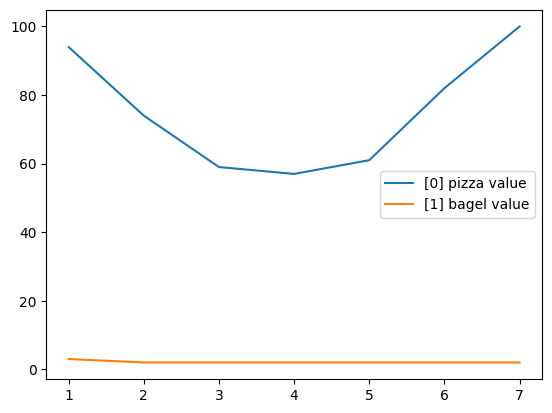

In [68]:
data[['[0] pizza value', '[1] bagel value']].plot()

### **1.1. Métodos gerais**

In [ ]:
pytrend = TrendReq()

In [ ]:
pytrend

In [ ]:
pytrend.trending_searches(pn = 'brazil')

,0
0,Flamengo x Internacional
1,Arsenal
2,Lazio
3,Orçamento secreto
4,Cuiabá x Flamengo
5,Numanice RJ
6,Meningite
7,West Ham
8,Fenerbahçe
9,Eliane Lorett


In [ ]:
pytrend_BR = TrendReq(hl = 'pt-BR', tz  = 180, geo = 'BR')

In [ ]:
pytrend_BR.trending_searches()

,0
0,Omonia vs Man United
1,Broncos
2,Lakers
3,Pixel 7
4,Arsenal vs Bodø/Glimt
5,Thailand
6,Merced family kidnapped
7,Britney Spears
8,Ben Sasse
9,DACA


In [ ]:
# Trends anuais

pytrend.top_charts(2021, hl = 'pt-BR', geo = 'BR')

,title,exploreQuery
0,Marília Mendonça,
1,Eurocopa,
2,Palmeiras,
3,Libertadores,
4,Brasileirão,
5,Corinthians,
6,Copa do Brasil,
7,MC Kevin,
8,Copa América,
9,Lázaro Barbosa,lazaro


### Busca por várias keywords

In [ ]:
keyword = ['Apple','Amazon','Tesla','Petrobras']
pytrend.build_payload(keyword, timeframe = '2022-01-01 2022-10-06', geo = '')

In [ ]:
busca_stocks = pytrend.interest_over_time()

In [ ]:
busca_stocks.head()

,Apple,Amazon,Tesla,Petrobras,isPartial
date,,,,,
2022-01-02,36,90,8,0,False
2022-01-09,34,83,7,0,False
2022-01-16,30,86,7,0,False
2022-01-23,31,83,8,0,False
2022-01-30,32,85,7,0,False


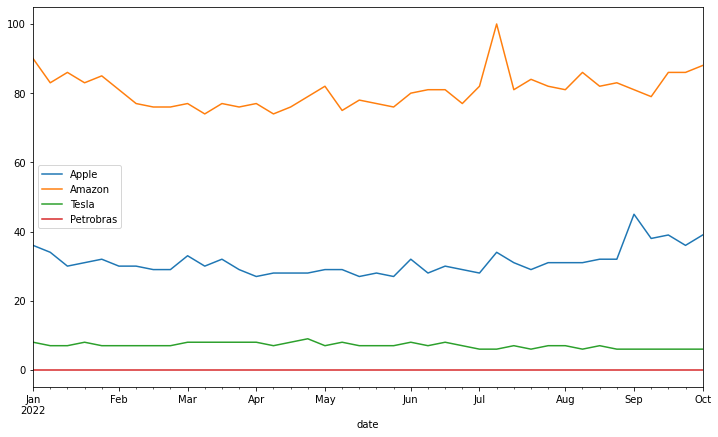

In [ ]:
busca_stocks[[ 	'Apple',	'Amazon',	'Tesla',	'Petrobras' ]].plot(figsize = (12, 7))

# **3. Backtesting Bitcoin: trends x preço**

In [ ]:
# ESTE TRECHO DE CÓDIGO VAI CAIR

pytrend = TrendReq()

kw_list=['Bitcoin']
historical_trend_BTC = pytrend.get_historical_interest(kw_list, year_start=2018, month_start=1, day_start=1, hour_start=0,
                                                   year_end=2022, month_end=10, day_end=5, hour_end=0, geo='', sleep=0, frequency='daily')

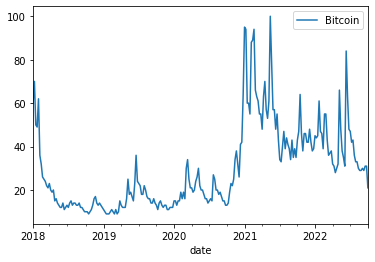

In [ ]:
pytrend = TrendReq()

kw_list=['Bitcoin']

pytrend.build_payload(kw_list, timeframe='2018-01-01 2022-10-05', cat=7, geo='')

pytrend.interest_over_time().plot()

In [ ]:
dados_weekly_trends = pytrend.interest_over_time()
dados_weekly_trends

,Bitcoin,isPartial
date,,
2018-01-07,60,False
2018-01-14,70,False
2018-01-21,50,False
2018-01-28,49,False
2018-02-04,62,False
...,...,...
2022-09-04,30,False
2022-09-11,29,False
2022-09-18,31,False


In [ ]:
price_BTC = yf.download('BTC-USD', start='2018-01-01', end='2022-10-05')[['Close']]
price_BTC

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2018-01-01 00:00:00+00:00,13657.200195
2018-01-02 00:00:00+00:00,14982.099609
2018-01-03 00:00:00+00:00,15201.000000
2018-01-04 00:00:00+00:00,15599.200195
2018-01-05 00:00:00+00:00,17429.500000
...,...
2022-09-30 00:00:00+00:00,19431.789062
2022-10-01 00:00:00+00:00,19312.095703
2022-10-02 00:00:00+00:00,19044.107422


In [ ]:
# Uma diferença é visivel entre os dois dataframes: o formato do índice
# Antes de juntar os dataframes, vamos criar uma coluna que seja comum entre eles

price_BTC['Data'] = price_BTC.index.date
dados_weekly_trends['Data'] = dados_weekly_trends.index.date
price_BTC

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Close,Data
Date,,
2018-01-01 00:00:00+00:00,13657.200195,2018-01-01
2018-01-02 00:00:00+00:00,14982.099609,2018-01-02
2018-01-03 00:00:00+00:00,15201.000000,2018-01-03
2018-01-04 00:00:00+00:00,15599.200195,2018-01-04
2018-01-05 00:00:00+00:00,17429.500000,2018-01-05
...,...,...
2022-09-30 00:00:00+00:00,19431.789062,2022-09-30
2022-10-01 00:00:00+00:00,19312.095703,2022-10-01
2022-10-02 00:00:00+00:00,19044.107422,2022-10-02


In [ ]:
# Usar o merge para manter apenas os preços de fechamento de Bitcoin semanais (existiriam outras formas mais "elegantes" de fazer, como usando o resample)

df_close_trends = pd.merge(price_BTC, dados_weekly_trends[['Bitcoin', 'Data']], left_on='Data', right_on='Data', how='inner')
df_close_trends

,Close,Data,Bitcoin
0,16477.599609,2018-01-07,60
1,13772.000000,2018-01-14,70
2,11600.099609,2018-01-21,50
3,11786.299805,2018-01-28,49
4,8277.009766,2018-02-04,62
...,...,...,...
243,19986.712891,2022-09-04,30
244,21769.255859,2022-09-11,29
245,19419.505859,2022-09-18,31
246,18802.097656,2022-09-25,31


In [ ]:
# Agora, voltaremos o index do df para datetime usando a coluna Data, ao mesmo tempo q a excluímos

df_close_trends.index = pd.to_datetime(df_close_trends.Data, infer_datetime_format=True)
df_close_trends.drop('Data', axis=1, inplace=True)
df_close_trends

,Close,Bitcoin
Data,,
2018-01-07,16477.599609,60
2018-01-14,13772.000000,70
2018-01-21,11600.099609,50
2018-01-28,11786.299805,49
2018-02-04,8277.009766,62
...,...,...
2022-09-04,19986.712891,30
2022-09-11,21769.255859,29
2022-09-18,19419.505859,31


In [ ]:
# Vamos normalizar os dados de preço e trends para que fiquem em uma unidade comparável

df_close_trends_norm = df_close_trends/df_close_trends.iloc[0]
df_close_trends_norm

,Close,Bitcoin
Data,,
2018-01-07,1.000000,1.000000
2018-01-14,0.835801,1.166667
2018-01-21,0.703992,0.833333
2018-01-28,0.715292,0.816667
2018-02-04,0.502319,1.033333
...,...,...
2022-09-04,1.212963,0.500000
2022-09-11,1.321142,0.483333
2022-09-18,1.178540,0.516667


In [ ]:
df_close_trends_norm.vbt.plot().update_layout(template='simple_white', width=800, height=400,
                                              title_text='<b>Bitcoin: preço x trends',
                                              xaxis_title="<b>Data", yaxis_title="<b>Valor normalizado").show()

Ao olhar pro gráfico acima, fica bem sugestivo que as duas variáveis estão caminhando juntas.

Para backtestar nossa teoria, poderíamos pensar em uma estratégia de comprar o ativo nos momentos onde houve aumento das pesquisas em relação aos períodos anteriores

Nesse sentido, o desvio padrão pode ser uma ferramenta interessante para ver quanto as pesquisas estão divergindo da média

As bandas de bollinger podem nos ajudar nessa tarefa. Elas são representadas por 3 linhas, onde:

* A linha central é a média de n períods atrás (vamos definir n como 10, ou seja, média dos últimos 10 dias)
* A linha superior = média + x desvios (aqui vamos definir x como 1)
* A linha inferior = média - x desvios (aqui vamos definir x como 1)

OBS: Tradicionalmente as Bandas de Bollinger são o preço de 20 períodos +- 2 desvios

In [ ]:
# Observação: a legenda da figura traz "Close", mas ela representa o número de pesquisas

vbt.BBANDS.run(df_close_trends['Bitcoin'], 10, alpha=1).\
plot(template='simple_white', width=800, height=400).show()

Agora extraímos os valores das bandas superior e inferior para usar nos sinais de entrada

In [ ]:
BBand_sup_1std = vbt.BBANDS.run(df_close_trends['Bitcoin'], 10, alpha=1).upper
BBand_inf_1std = vbt.BBANDS.run(df_close_trends['Bitcoin'], 10, alpha=1).lower

Criamos uma estrutura booleana, se o número de pesquisas cruzar para cima a banda superior, compramos (entradas). Quando procurar ficarem abaixo da banda inferior, venderemos (exits)

In [ ]:
entradas = df_close_trends['Bitcoin'].vbt.crossed_above(BBand_sup_1std)
saidas = df_close_trends['Bitcoin'].vbt.crossed_below(BBand_inf_1std)

Usando a vectorbt, criamos nosso backtesting, informando as variações no preço, nossas entradas e saidas, a frequencia para plotagem (W, weekly) além de outros parâmetros.

Para fins de simplificação, mostraremos apenas a ponta compradora (longonly) e não exploraremos os diversos parâmetros da biblioteca para otimizar o backtest e as estrategias

In [ ]:
setup_sentim_BTC = vbt.Portfolio.from_signals(df_close_trends['Close'], entradas, saidas, direction='longonly', freq='W')

In [ ]:
setup_sentim_BTC.plot().show()

In [ ]:
setup_sentim_BTC.stats()

Start                         2018-01-07 00:00:00+00:00
End                           2022-10-02 00:00:00+00:00
Period                               1736 days 00:00:00
Start Value                                       100.0
End Value                                    703.709282
Total Return [%]                             603.709282
Benchmark Return [%]                          15.575738
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              61.101944
Max Drawdown Duration                 322 days 00:00:00
Total Trades                                         10
Total Closed Trades                                  10
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                       50.0
Best Trade [%]                               411.684367
Worst Trade [%]                              -36